| | |
|-|-|
| ![gym](images/gym.png) | ![img](images/pytorch.png) |

### Домашнее задание

Является взаимодополняющим с заданием по контекстным бандитам, в сумме достаточно набрать 10 баллов.

1. [5 баллов] Для произвольно выбранной игры из набора Atari реализовать нейросетевого агента для среды из регистров памяти.

2. [5 баллов] Реализовать агента для среды со снимками экрана и сравнить с первым агентом.

Приведите логи изменения продолжительности игры или количества набранных очков.

Приложите ссылку на запись с моментами из игры обученного агента.

In [32]:
# The typical imports
import gym
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Imports specifically so we can render outputs in Jupyter.
from JSAnimation.IPython_display import display_animation
from matplotlib import animation
from IPython.display import display


def display_frames_as_gif(frames):
    """
    Displays a list of frames as a gif, with controls
    """
    #plt.figure(figsize=(frames[0].shape[1] / 72.0, frames[0].shape[0] / 72.0), dpi = 72)
    patch = plt.imshow(frames[0])
    plt.axis('off')

    def animate(i):
        patch.set_data(frames[i])

    anim = animation.FuncAnimation(plt.gcf(), animate, frames = len(frames), interval=50)
    display(display_animation(anim, default_mode='loop'))

На этом занятии будем использовать библиотеку [openai](https://openai.com/systems/) `gym`, `pytorch` также будет использоваться для обучения.

In [ ]:
# !pip install pyglet==1.2.4
# !pip install gym==0.8.2

# Reinforcement Learning Recap

Агент взаимодействует со средой через действия (**A**), изменяя свое состояние (**S**) и получая вознаграждение (**R**).

Итоговая цель -- максимизировать суммарное вознаграждение.

![](images/recap.png)

## Тележка

![](images/cartpole.png)

* **Цель** - как можно дольше удерживать стержень вертикально
* **Состояние** - угол, угловая скорость, положение, горизонтальная скорость
* **Действие** - горизонтальная сила, применяемая к тележке
* **Вознаграждение** - 1 за каждый момент времени с околовертикальным стержнем (например, 85-95 градусов)

## Atari

![](images/atari.png)

* **Цель** - побить рекорд по очкам
* **Состояние** - экран игры (изображение)
* **Действие** - различные клавиши
* **Вознаграждение** - определяется игрой

## Doom

![](images/doom.png)

* **Цель** - уничтожить всех противников
* **Состояние** - экран игры (изображение)
* **Действие** - различные клавиши
* **Вознаграждение** - +1 при убийстве противника, -N при смерти героя

## Дисконтирование вознаграждений

В задачах обучения с подкреплениям часто вводится дисконтирующий коэффицент $\gamma$.

Без него суммарное вознаграждение за все будущие состояние с момента $t$ может быть определено как

![](images/nodiscount.png)

С ним же мы отдаем предпочтения больше текущим вознаграждениям, чем будущим, т.к. среда может быть изменчива:

![](images/discount.png)


## Функция ценности

Хочется для каждого состояния знать, насколько оно "хорошее" (valuable). Тогда мы бы знали, чего ожидать от перехода в данное состояние.

Для этого и существуют функции ценности -- они вычисляют средний дисконтированный выигрыш при следовании некоторой стратегии $\pi$.

![](images/vpolicy.png)

Существует также и функция, определяющая оптимальную оценку состояния как максимум оценок среди всех стратегий.

![](images/voptimal.png)

## Q-функция

Даже при наличии оптимальных оценок состояний, мы все еще не можем их произвольно устанавливать, а только выбирать действие `a`.

Для эффективного выбора действия при некотором состояния есть еще Q-функция (оценивающая Quality$\approx$эффективность такого действия).

Более формально -- $Q^\pi(s, a)$ выражает ожидаемое вознаграждение при выполнении действия `a` и дальнейшем следовании стратегии $\pi$.

Также как и с оценкой состоянии существует некоторая оптимальная $Q^*(s, a)$.

Между двумя оптимальными функциями можно установить тождество:

![](images/VQ.png)

А оптимальная стратегия в свою очередь выражается через оптимальную Q-функцию:

![](images/pioptimal.png)

**Задача** поиска оптимальной стратегии для агента в итоге **сводится к определению $V^*$ и $Q^*$**.

## Q-learning

Q(s, a) можно определить рекурсивно через уравнение Беллмана как

![](images/bellman.png)

Идея Q-обучения состоит в том, чтобы исходя из уравнения Беллмана оценивать Q итеративно:

![](images/qiter.png)

Изначально это ничего не дает, т.к. базовые аппроксимации будут случайными. Но чем больше узнает агент, тем ближе мы к $Q^*$.

# "Самодельная" среда

![](images/zombie.png)

Хотим съесть мороженое, и не натыкаться на зомби, действия -- выбор одной из 4 сторон для перемещения.

Начальное состояние среды:

In [33]:
ZOMBIE = "z"
CAR = "c"
ICE_CREAM = "i"
EMPTY = "*"

grid = [
    [ICE_CREAM, EMPTY],
    [ZOMBIE, CAR]
]

for row in grid:
    print(' '.join(row))

i *
z c


Класс состояний

In [34]:
class State:
    def __init__(self, grid, car_pos):
        self.grid = grid
        self.car_pos = car_pos
        
    def __eq__(self, other):
        return isinstance(other, State) and self.grid == other.grid and self.car_pos == other.car_pos
    
    def __hash__(self):
        return hash(str(self.grid) + str(self.car_pos))
    
    def __str__(self):
        return f"State(grid={self.grid}, car_pos={self.car_pos})"

    def __repr__(self):
        return self.__str__()

Действия

In [35]:
UP = 0
DOWN = 1
LEFT = 2
RIGHT = 3

ACTIONS = [UP, DOWN, LEFT, RIGHT]

И опять же начальное состояние

In [36]:
start_state = State(grid=grid, car_pos=[1, 1])
start_state

State(grid=[['i', '*'], ['z', 'c']], car_pos=[1, 1])

Функция взаимодействия

In [37]:
from copy import deepcopy

def act(state, action):
    def new_car_pos(state, action):
        p = deepcopy(state.car_pos)
        if action == UP:
            p[0] = max(0, p[0] - 1)
        elif action == DOWN:
            p[0] = min(len(state.grid) - 1, p[0] + 1)
        elif action == LEFT:
            p[1] = max(0, p[1] - 1)
        elif action == RIGHT:
            p[1] = min(len(state.grid[0]) - 1, p[1] + 1)
        else:
            raise ValueError(f"Unknown action {action}")
        return p

    p = new_car_pos(state, action)
    grid_item = state.grid[p[0]][p[1]]
    
    new_grid = deepcopy(state.grid)
    
    if grid_item == ZOMBIE:
        reward = -100
        is_done = True
        new_grid[p[0]][p[1]] += CAR
    elif grid_item == ICE_CREAM:
        reward = 1000
        is_done = True
        new_grid[p[0]][p[1]] += CAR
    elif grid_item == EMPTY:
        reward = -1
        is_done = False
        old = state.car_pos
        new_grid[old[0]][old[1]] = EMPTY
        new_grid[p[0]][p[1]] = CAR
    elif grid_item == CAR:
        reward = -1
        is_done = False
    else:
        raise ValueError(f"Unknown grid item {grid_item}")

    return State(grid=new_grid, car_pos=p), reward, is_done

Обучение

In [38]:
import numpy as np
import random

random.seed(42)

N_STATES = 4
N_EPISODES = 20

MAX_EPISODE_STEPS = 100

MIN_ALPHA = 0.02

alphas = np.linspace(1.0, MIN_ALPHA, N_EPISODES)
gamma = 1.0
eps = 0.2

q_table = dict()

In [39]:
def q(state, action=None):
    if state not in q_table:
        q_table[state] = np.zeros(len(ACTIONS))
        
    if action is None:
        return q_table[state]
    
    return q_table[state][action]

In [40]:
def choose_action(state):
    if random.uniform(0, 1) < eps:
        return random.choice(ACTIONS) 
    else:
        return np.argmax(q(state))

In [41]:
for e in range(N_EPISODES):
    state = start_state
    total_reward = 0
    alpha = alphas[e]
    
    for _ in range(MAX_EPISODE_STEPS):
        action = choose_action(state)
        next_state, reward, done = act(state, action)
        total_reward += reward
        
        q(state)[action] = q(state, action) + \
                alpha * (reward + gamma *  np.max(q(next_state)) - q(state, action))
        state = next_state
        if done:
            break
    print(f"Episode {e + 1}: total reward -> {total_reward}")

Episode 1: total reward -> 999
Episode 2: total reward -> 998
Episode 3: total reward -> 997
Episode 4: total reward -> 997
Episode 5: total reward -> 999
Episode 6: total reward -> 999
Episode 7: total reward -> 998
Episode 8: total reward -> -100
Episode 9: total reward -> -101
Episode 10: total reward -> 999
Episode 11: total reward -> 999
Episode 12: total reward -> 999
Episode 13: total reward -> 999
Episode 14: total reward -> 999
Episode 15: total reward -> 999
Episode 16: total reward -> 998
Episode 17: total reward -> 999
Episode 18: total reward -> 999
Episode 19: total reward -> 999
Episode 20: total reward -> 999


In [42]:
q_table

{State(grid=[['i', '*'], ['z', 'c']], car_pos=[1, 1]): array([998.9999565 , 225.12936017, -85.10182825, 586.19245204]),
 State(grid=[['i', '*'], ['zc', 'c']], car_pos=[1, 0]): array([0., 0., 0., 0.]),
 State(grid=[['i', 'c'], ['z', '*']], car_pos=[0, 1]): array([ 895.94526316,  842.8767095 , 1000.        ,  967.10727091]),
 State(grid=[['ic', 'c'], ['z', '*']], car_pos=[0, 0]): array([0., 0., 0., 0.])}

In [47]:
start_state

State(grid=[['i', '*'], ['z', 'c']], car_pos=[1, 1])

In [48]:
state_1 = act(start_state, choose_action(start_state))[0]
state_1

State(grid=[['i', 'c'], ['z', '*']], car_pos=[0, 1])

In [49]:
state_2 = act(state_1, choose_action(state_1))[0]
state_2

State(grid=[['i', '*'], ['z', 'c']], car_pos=[1, 1])

# Openai Gym

In [55]:
env = gym.make('CartPole-v0')
env.reset()
for t in range(5000):
    env.render()
    action = env.action_space.sample()
    observation, reward, done, info = env.step(action)
    if done:
        break
env.close()

[2018-04-18 20:32:59,691] Making new env: CartPole-v0


In [56]:
observation

array([ 0.08355633,  0.55682708, -0.21051092, -1.24616204])

In [57]:
reward

1.0

In [58]:
done

True

In [59]:
info

{}

In [60]:
def demo(name):
    env = gym.make(name)
    try:
        for i_episode in range(5):
            observation = env.reset()
            for t in range(200):
                env.render()
                action = env.action_space.sample()
                observation, reward, done, info = env.step(action)
                if done:
                    print("Episode finished after {} timesteps".format(t+1))
                    env.close()
    finally:
        env.close()

In [62]:
demo('Pong-v0')

[2018-04-18 20:35:30,817] Making new env: Pong-v0


In [63]:
print(env.action_space)

Discrete(2)


In [64]:
print(env.observation_space)

Box(4,)


In [65]:
print(env.observation_space.high)

[4.80000000e+00 3.40282347e+38 4.18879020e-01 3.40282347e+38]


In [66]:
print(env.observation_space.low)

[-4.80000000e+00 -3.40282347e+38 -4.18879020e-01 -3.40282347e+38]


In [67]:
from gym import spaces
space = spaces.Discrete(8) # Set with 8 elements {0, 1, 2, ..., 7}
x = space.sample()
assert space.contains(x)
assert space.n == 8

In [68]:
demo('MountainCar-v0')

[2018-04-18 20:37:55,306] Making new env: MountainCar-v0


Episode finished after 200 timesteps
Episode finished after 200 timesteps
Episode finished after 200 timesteps
Episode finished after 200 timesteps
Episode finished after 200 timesteps


In [70]:
demo('Breakout-v0')

[2018-04-18 20:39:10,083] Making new env: Breakout-v0


Episode finished after 166 timesteps
Episode finished after 167 timesteps
Episode finished after 168 timesteps
Episode finished after 169 timesteps
Episode finished after 170 timesteps
Episode finished after 171 timesteps
Episode finished after 172 timesteps
Episode finished after 173 timesteps
Episode finished after 174 timesteps
Episode finished after 175 timesteps
Episode finished after 176 timesteps
Episode finished after 177 timesteps
Episode finished after 178 timesteps
Episode finished after 179 timesteps
Episode finished after 180 timesteps
Episode finished after 181 timesteps
Episode finished after 182 timesteps
Episode finished after 183 timesteps
Episode finished after 184 timesteps
Episode finished after 185 timesteps
Episode finished after 186 timesteps
Episode finished after 187 timesteps
Episode finished after 188 timesteps
Episode finished after 189 timesteps
Episode finished after 190 timesteps
Episode finished after 191 timesteps
Episode finished after 192 timesteps
E

# Обучение модели

In [71]:
import gym
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple
from itertools import count
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
import torchvision.transforms as T


env = gym.make('CartPole-v0').unwrapped

# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

# if gpu is to be used
use_cuda = torch.cuda.is_available()
FloatTensor = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor
LongTensor = torch.cuda.LongTensor if use_cuda else torch.LongTensor
ByteTensor = torch.cuda.ByteTensor if use_cuda else torch.ByteTensor
Tensor = FloatTensor

[2018-04-18 20:45:18,723] Making new env: CartPole-v0


In [72]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))


class ReplayMemory(object):

    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def push(self, *args):
        """Saves a transition."""
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = Transition(*args)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [73]:
class DQN(nn.Module):

    def __init__(self):
        super(DQN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=5, stride=2)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5, stride=2)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 32, kernel_size=5, stride=2)
        self.bn3 = nn.BatchNorm2d(32)
        self.head = nn.Linear(448, 2)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        return self.head(x.view(x.size(0), -1))

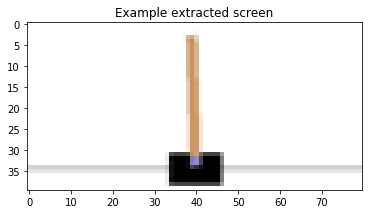

In [74]:
resize = T.Compose([T.ToPILImage(),
                    T.Resize(40, interpolation=Image.CUBIC),
                    T.ToTensor()])

# This is based on the code from gym.
screen_width = 600


def get_cart_location():
    world_width = env.x_threshold * 2
    scale = screen_width / world_width
    return int(env.state[0] * scale + screen_width / 2.0)  # MIDDLE OF CART


def get_screen():
    screen = env.render(mode='rgb_array').transpose(
        (2, 0, 1))  # transpose into torch order (CHW)
    # Strip off the top and bottom of the screen
    screen = screen[:, 160:320]
    view_width = 320
    cart_location = get_cart_location()
    if cart_location < view_width // 2:
        slice_range = slice(view_width)
    elif cart_location > (screen_width - view_width // 2):
        slice_range = slice(-view_width, None)
    else:
        slice_range = slice(cart_location - view_width // 2,
                            cart_location + view_width // 2)
    # Strip off the edges, so that we have a square image centered on a cart
    screen = screen[:, :, slice_range]
    # Convert to float, rescare, convert to torch tensor
    # (this doesn't require a copy)
    screen = np.ascontiguousarray(screen, dtype=np.float32) / 255
    screen = torch.from_numpy(screen)
    # Resize, and add a batch dimension (BCHW)
    return resize(screen).unsqueeze(0).type(Tensor)


env.reset()
plt.figure()
plt.imshow(get_screen().cpu().squeeze(0).permute(1, 2, 0).numpy(),
           interpolation='none')
plt.title('Example extracted screen')
plt.show()

In [75]:
BATCH_SIZE = 128
GAMMA = 0.999
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 200
TARGET_UPDATE = 10

policy_net = DQN()
target_net = DQN()
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

if use_cuda:
    policy_net.cuda()
    target_net.cuda()

optimizer = optim.RMSprop(policy_net.parameters())
memory = ReplayMemory(10000)


steps_done = 0


def select_action(state):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        return policy_net(
            Variable(state, volatile=True).type(FloatTensor)).data.max(1)[1].view(1, 1)
    else:
        return LongTensor([[random.randrange(2)]])


episode_durations = []


def plot_durations():
    plt.figure(2)
    plt.clf()
    durations_t = torch.FloatTensor(episode_durations)
    plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(durations_t.numpy())
    # Take 100 episode averages and plot them too
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())

    plt.pause(0.001)  # pause a bit so that plots are updated
    if is_ipython:
        display.clear_output(wait=True)
        display.display(plt.gcf())

In [77]:
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    # Transpose the batch (see http://stackoverflow.com/a/19343/3343043 for
    # detailed explanation).
    batch = Transition(*zip(*transitions))

    # Compute a mask of non-final states and concatenate the batch elements
    non_final_mask = ByteTensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)))
    non_final_next_states = Variable(torch.cat([s for s in batch.next_state
                                                if s is not None]),
                                     volatile=True)
    state_batch = Variable(torch.cat(batch.state))
    action_batch = Variable(torch.cat(batch.action))
    reward_batch = Variable(torch.cat(batch.reward))

    # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
    # columns of actions taken
    state_action_values = policy_net(state_batch).gather(1, action_batch)

    # Compute V(s_{t+1}) for all next states.
    next_state_values = Variable(torch.zeros(BATCH_SIZE).type(Tensor))
    next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0]
    # Compute the expected Q values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch
    # Undo volatility (which was used to prevent unnecessary gradients)
    expected_state_action_values = Variable(expected_state_action_values.data)

    # Compute Huber loss
    loss = F.smooth_l1_loss(state_action_values, expected_state_action_values)

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    for param in policy_net.parameters():
        param.grad.data.clamp_(-1, 1)
    optimizer.step()

In [78]:
num_episodes = 50
for i_episode in range(num_episodes):
    # Initialize the environment and state
    env.reset()
    last_screen = get_screen()
    current_screen = get_screen()
    state = current_screen - last_screen
    for t in count():
        # Select and perform an action
        action = select_action(state)
        _, reward, done, _ = env.step(action[0, 0])
        reward = Tensor([reward])

        # Observe new state
        last_screen = current_screen
        current_screen = get_screen()
        if not done:
            next_state = current_screen - last_screen
        else:
            next_state = None

        # Store the transition in memory
        memory.push(state, action, next_state, reward)

        # Move to the next state
        state = next_state

        # Perform one step of the optimization (on the target network)
        optimize_model()
        if done:
            episode_durations.append(t + 1)
            plot_durations()
            break
    # Update the target network
    if i_episode % TARGET_UPDATE == 0:
        target_net.load_state_dict(policy_net.state_dict())

print('Complete')
env.render(close=True)
env.close()
plt.ioff()
plt.show()

Complete


In [79]:
len(memory)

858